### Range of input variables

We want to check if the numerical models are falling out of range

In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
from datatree import DataTree
from datatree import open_datatree

import xgcm

import sys
sys.path.append('../modules/')
import helper_func as hf

# Import seaborn
import seaborn as sns

In [5]:
import os
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']
data_bucket = 'gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/'

In [7]:
Lkey = ['50', '100', '200', '400']

res_name = 'all'

ds = {}

for L in Lkey: 
    Lsel = int(L)

    ds_temp = xr.open_zarr(f'{data_bucket}res4km_sponge10day_long_ml_data_'+L+'km.zarr').sel(yh=slice(float(Lsel), 1600-float(Lsel)))
    
    ds[L] = ds_temp 

ds_tree = DataTree.from_dict(ds)

In [43]:
def ML_vars(ds_L, choice=0):
    
    ds_test = xr.Dataset()
    
    ds_test['Sx'] = ds_L.slope_x.isel(zi=1)
    ds_test['Sy'] = ds_L.slope_y.isel(zi=1)
    #ds_test['Lfilt'] = ds_L.h.isel(zl=0)*0. + L
    
    # For the gradients we have some choices to make 
    
    #choice = 0 # 0 thickness weighted, 1 bottom layer, 2 top layer
    # Choose 0, since that is what we are currently using in online sims
    if choice == 0:
        ds_test['U_x'] = (ds_L.dudx * ds_L.h).sum('zl') / ds_L.h.sum('zl')
        ds_test['U_y'] = (ds_L.dudy * ds_L.h).sum('zl') / ds_L.h.sum('zl')
        ds_test['V_x'] = (ds_L.dvdx * ds_L.h).sum('zl') / ds_L.h.sum('zl')
        ds_test['V_y'] = (ds_L.dvdy * ds_L.h).sum('zl') / ds_L.h.sum('zl')
    elif choice ==1: 
        ds_test['U_x'] = ds_L.dudx.isel(zl=1)
        ds_test['U_y'] = ds_L.dudy.isel(zl=1)
        ds_test['V_x'] = ds_L.dvdx.isel(zl=1)
        ds_test['V_y'] = ds_L.dvdy.isel(zl=1)
        
    ds_test['Sfnx'] = ds_L.uh_sg.isel(zl=1)
    ds_test['Sfny'] = ds_L.vh_sg.isel(zl=1)
    
    ds_test['SG_KE'] = 0.5*(ds_L.uu_sg.isel(zl=1) + ds_L.vv_sg.isel(zl=1))
    
    ds_test['grad_mag'] = (ds_test.U_x**2 + ds_test.V_x**2 + ds_test.U_y**2 + ds_test.U_y**2)**0.5
    ds_test['slope_mag'] = (ds_test.Sx**2 + ds_test.Sy**2)**0.5
    ds_test['SG_flux_mag'] = (ds_test.Sfnx**2 + ds_test.Sfny**2)**0.5
    
    return ds_test

In [40]:
output_channels = ['Sfnx','Sfny']                                      

input_channels = ['U_x', 'U_y', 
                  'V_x', 'V_y', 
                  'Sx', 'Sy', 'SG_KE']

In [41]:
L = '100'
ds_ML_100 = ML_vars(ds_tree[L].ds.isel(Time=slice(100, 400)), choice=1)

In [42]:
ds_ML_100.load(); 

In [36]:
vars_plot = ['U_x', 'U_y','V_x', 'V_y', 'Sx', 'Sy', 'Sfnx', 'Sfny']

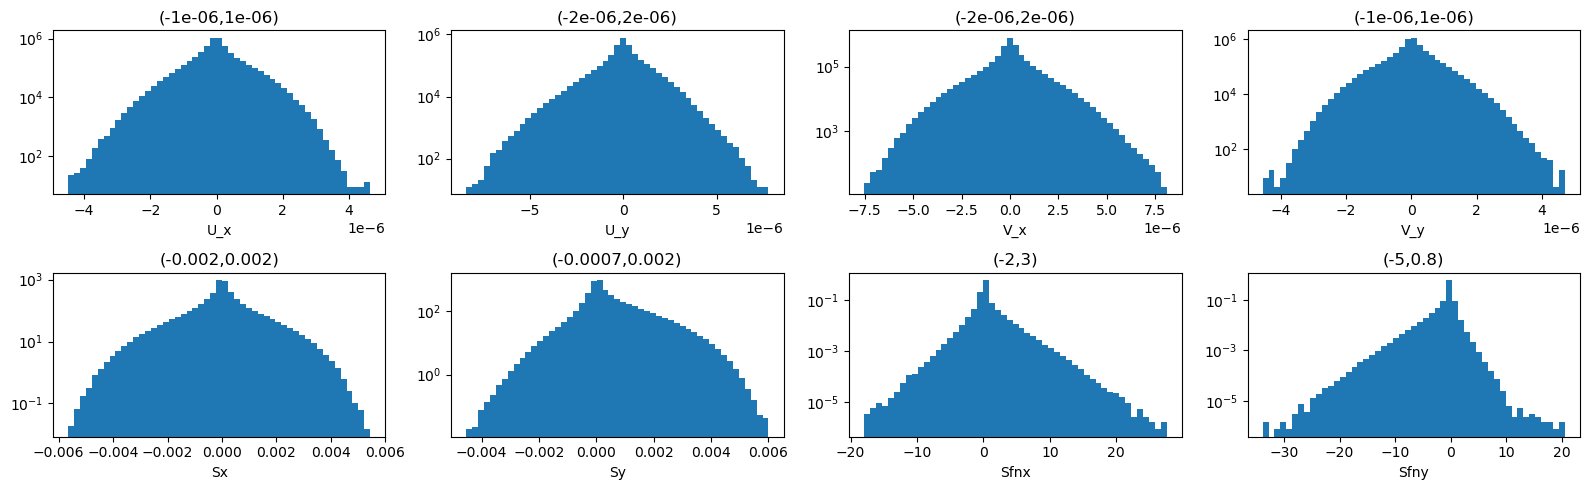

In [37]:
fig, ax = plt.subplots(2, 4, figsize=(16, 5)) 

for i, var in enumerate(vars_plot): 
    dvals = ds_ML_100[var].values.reshape(-1)
    if i<4:
        ax[0,i].hist(dvals, bins=51, density=True)
        ax[0,i].set_yscale('log')
        ax[0,i].set_xlabel(var)
        ranges = np.percentile(dvals, (5, 95))
        ax[0,i].set_title('(%.1g' % ranges[0]+',%.1g)'%ranges[1])
    else:
        ax[1,i-4].hist(dvals, bins=51, density=True)
        ax[1,i-4].set_yscale('log')
        ax[1,i-4].set_xlabel(var)
        ranges = np.percentile(dvals, (5, 95))
        ax[1,i-4].set_title('(%.1g' % ranges[0]+',%.1g)'%ranges[1])

plt.tight_layout()

#plt.sample
#plt.savefig('var_dist_'+L+'.pdf')

In [38]:
ds_ML_100

<xarray.Dataset>
Dimensions:  (Time: 300, xh: 60, yh: 70)
Coordinates:
  * Time     (Time) object 0003-10-08 00:00:00 ... 0011-12-15 00:00:00
  * xh       (xh) float64 10.0 30.0 50.0 70.0 ... 1.15e+03 1.17e+03 1.19e+03
  * yh       (yh) float64 110.0 130.0 150.0 170.0 ... 1.45e+03 1.47e+03 1.49e+03
    zi       float64 1.032e+03
    zl       float64 1.033e+03
Data variables:
    Sx       (Time, yh, xh) float32 -5.296e-05 -1.26e-05 ... 4.656e-07
    Sy       (Time, yh, xh) float32 -2.795e-05 -4.503e-05 ... 2.905e-05
    U_x      (Time, yh, xh) float32 1.382e-08 1.311e-08 ... 1.379e-07 1.785e-07
    U_y      (Time, yh, xh) float32 -1.835e-07 -1.976e-07 ... 2.067e-07
    V_x      (Time, yh, xh) float32 1.45e-08 -1.634e-09 ... -7.189e-08 4.028e-09
    V_y      (Time, yh, xh) float32 -1.442e-08 -1.42e-08 ... -1.785e-07
    Sfnx     (Time, yh, xh) float64 0.003234 0.005912 ... -0.001324 0.01011
    Sfny     (Time, yh, xh) float64 0.001282 0.003262 ... 0.01207 0.002639
    SG_KE    (Time, yh, xh) float32 1.437e-05 1.662e-05 ... 4.703e-05 5.096e-05

Check scale dependence 

In [44]:
for L in Lkey: 
    ds_ML = ML_vars(ds_tree[L].ds.isel(Time=slice(100, 400)), choice=1)
    grad_mag = ds_ML.grad_mag.mean()
    slope_mag = ds_ML.slope_mag.mean()
    SG_KE_mag = ds_ML.SG_KE.mean()
    SG_flux_mag = ds_ML.SG_flux_mag.mean()
    
    print(L +  ',' +
          str(grad_mag.values) + ',' +
          str(slope_mag.values) + ',' +
          str(SG_KE_mag.values) + ',' +
          str(SG_flux_mag.values) 
         )

50,1.8671689e-06,0.0011756939,0.0006328756,0.47661948142141114
100,1.5868503e-06,0.0010431842,0.0020915794,1.462437304432097
200,1.0818978e-06,0.0008153323,0.005552665,3.4693349106689038
400,4.826473e-07,0.00073448877,0.011520492,6.25983702282695


In [46]:
L = '100'
ds_ML_100 = ML_vars(ds_tree[L].ds.isel(Time=slice(100, 400)), choice=1)

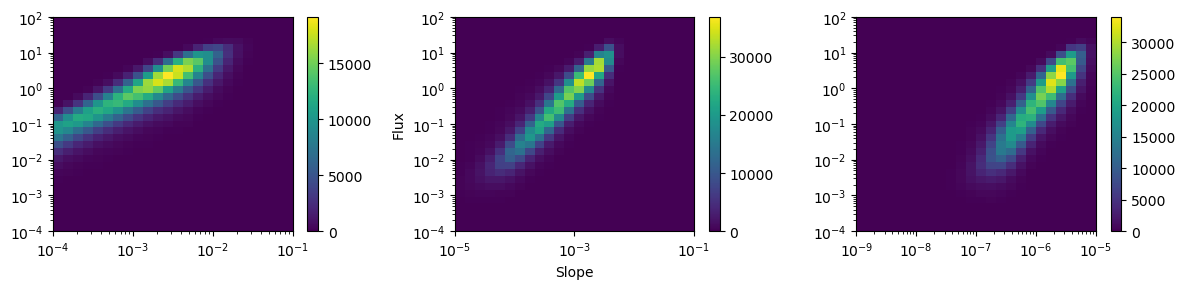

In [91]:
plt.figure(figsize=(12, 3)) 

plt.subplot(131)
bins_SG_KE = np.logspace(-4, -1, 25) 
bins_SG_flux = np.logspace(-4, 2, 32)

h = plt.hist2d(ds_ML_100.SG_KE.values.reshape(-1), 
                ds_ML_100.SG_flux_mag.values.reshape(-1), 
                bins=[bins_SG_KE, bins_SG_flux ] )
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

plt.subplot(132)
bins_slope_mag = np.logspace(-5, -1, 25) 
#bins_SG_flux = np.logspace(-4, 2, 32)

h = plt.hist2d(ds_ML_100.slope_mag.values.reshape(-1), 
                ds_ML_100.SG_flux_mag.values.reshape(-1), 
                bins=[bins_slope_mag, bins_SG_flux] )
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.xlabel('Slope')
plt.ylabel('Flux')

plt.subplot(133)
bins_slope_mag = np.logspace(-9, -5, 25) 
#bins_SG_flux = np.logspace(-4, 2, 32)

h = plt.hist2d(ds_ML_100.grad_mag.values.reshape(-1), 
                ds_ML_100.SG_flux_mag.values.reshape(-1), 
                bins=[bins_slope_mag, bins_SG_flux] )
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

plt.tight_layout()